In [1]:
import skimage
import skimage.io
import skimage.segmentation

from skimage import feature
from skimage import color
from skimage import filters

from skimage.filters import threshold_otsu, sobel
from skimage.measure import label, regionprops
from skimage.feature import peak_local_max

from skimage.morphology import *
from scipy import ndimage as ndi

import numpy as np

import matplotlib.pyplot as plt

from scipy.ndimage.morphology import distance_transform_edt

def show_image(img):
    """
    Show a single image
    """
    fig = plt.figure(figsize = (15,10))
    plt.imshow(img)

def save_image(img, name):
    skimage.io.imsave(name, img)

In [59]:
def otsu_image(image):
    gray = 1 - image
    threshold = threshold_otsu(gray.reshape(-1, gray.shape[1], 1))

    return binary_dilation(gray > threshold)

In [3]:
def filter_noise(img, threshold=0.3, m_w=40):
    label_image = label(img)

    for i, region in enumerate(regionprops(label_image)):
        bbox = region.bbox
        h = bbox[2] - bbox[0]
        w = bbox[3] - bbox[1]

        if region.major_axis_length == 0:
            continue

        ratio = region.minor_axis_length / region.major_axis_length

        box = label_image[bbox[0]:bbox[2],bbox[1]:bbox[3]]
        
        if ratio < threshold or max(h, w) > m_w or region.extent < threshold or min(w, h) / max(w, h) < threshold:
            sm = img[bbox[0]:bbox[2],bbox[1]:bbox[3]]
            sm[box == i + 1] = 0
            continue

    return img

In [61]:
def preprocess_image(image, grid, exterior):
    binary = binary_closing(np.any(otsu_image(image), axis=2))
    original = binary.copy()

    im = original
    im[exterior > 0] = 0
    im[grid > 0] = 0
    im = filters.gaussian(im, 2)
    im = feature.canny(im)
    im = im ^ filter_noise(im ^ remove_small_objects(im, 5000), threshold=0.1, m_w=100)
    im = dilation(im)
    im = im ^ filter_noise(im ^ remove_small_objects(im, 10000), threshold=0.1, m_w=100)
    im = dilation(im, disk(2))
    
    return original, im

In [45]:
def dist_map(binary, exterior):
    binary = 1 - binary

    distance = ndi.distance_transform_edt(binary)

    local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3, 3)), labels=binary)
    markers = ndi.label(local_maxi)[0]
    labels = watershed(-distance, markers, mask=binary)

    labels = labels + 1
    labels[exterior > 0] = 0

    n_dist = distance.copy()

    for i, reg in enumerate(regionprops(labels)):
        bbox = reg.bbox

        label_box = labels[bbox[0]:bbox[2],bbox[1]:bbox[3]]
        dists_box = n_dist[bbox[0]:bbox[2],bbox[1]:bbox[3]]
        
        label_filter = label_box == reg.label

        if dists_box[label_filter].shape[0] == 0:
            print(i+1, np.unique(label_box))
            continue
        
        h = bbox[2] - bbox[0]
        w = bbox[3] - bbox[1]

        val = np.max(dists_box[label_filter])
        dists_box[label_filter] = val

    return n_dist

In [66]:
def get_useless_edges(n_dist, exterior):
    sobel = filters.sobel(n_dist)
    v = sobel.copy()
    v[exterior > 0] = 11

    v = v > 40
    v[binary_dilation(binary_dilation(n_dist == 0))] = 0
    v[v * sobel > 100] = 0
    v = remove_small_objects(v, 100)

    return v

In [88]:
def filter_edges(edges):
    edges = edges.copy()
    labels = label(1 - edges, connectivity=1)

    for i, reg in enumerate(regionprops(labels)):
        bbox = reg.bbox

        nb_pix = reg.minor_axis_length * reg.major_axis_length
        pc_pix = reg.area / max(nb_pix, 1)

        if reg.area > 1000000:
            continue
        
        if nb_pix == 0 or pc_pix > 0.50:
            label_box = labels[bbox[0]:bbox[2],bbox[1]:bbox[3]]
            dists_box = edges[bbox[0]:bbox[2],bbox[1]:bbox[3]]

            label_filter = label_box == reg.label

            dists_box[label_filter] = 1

    return edges

In [52]:
def filter_roads(binary, edges, exterior, closing=False):
    filtered = binary.copy()
    filtered[edges > 0] = True

    if closing:
        filtered = binary_closing(binary_opening(filtered), disk(3))

    filtered[exterior > 0] = 1
    labels = label(1 - filtered, connectivity=1)

    for i, reg in enumerate(regionprops(labels)):
        bbox = reg.bbox

        h = bbox[2] - bbox[0]
        w = bbox[3] - bbox[1]

        ratio = reg.minor_axis_length / max(reg.major_axis_length, 1)

        if reg.perimeter > 8000 and (reg.perimeter / reg.area) < 0.05:
            continue

        if ratio < 0.1 and reg.minor_axis_length > 20.0:
            continue

        if max(w, h) < 3000 and (w + h) < 6000:
            label_box = labels[bbox[0]:bbox[2],bbox[1]:bbox[3]]
            dists_box = filtered[bbox[0]:bbox[2],bbox[1]:bbox[3]]

            label_filter = label_box == (i + 1)

            dists_box[label_filter] = 1

    return filtered

In [62]:
img = "003"
image = skimage.io.imread(f"results/{img}/02_preprocessed.png")
grid = skimage.io.imread(f"results/{img}/01_grid.png")
exterior = skimage.io.imread(f"results/{img}/01_exterior.png") 

In [63]:
original, binary = preprocess_image(image, grid, exterior)

In [64]:
n_dist = dist_map(binary, exterior)

In [79]:
edges = filters.sobel(n_dist)
edges[exterior > 0] = 11

edges = edges > 40
edges[n_dist > 300] = True
edges[get_useless_edges(n_dist, exterior) > 0] = False

In [89]:
edges = remove_small_holes(edges, 1000)
edges_filtered = filter_edges(edges)

In [90]:
v2 = filter_roads(binary, edges, exterior)
v2_filtered = filter_roads(binary, edges_filtered, exterior, True)
v2_diff = filter_edges((1 - (v2_filtered ^ v2))) > 0

result = v2 ^ v2_diff

In [91]:
f_result = remove_small_holes(result, 10000)
f_result = binary_closing(f_result, disk(3))

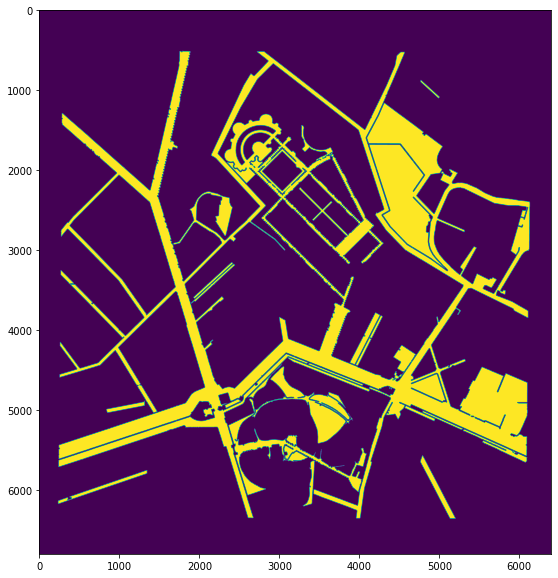

In [94]:
show_image(f_result)

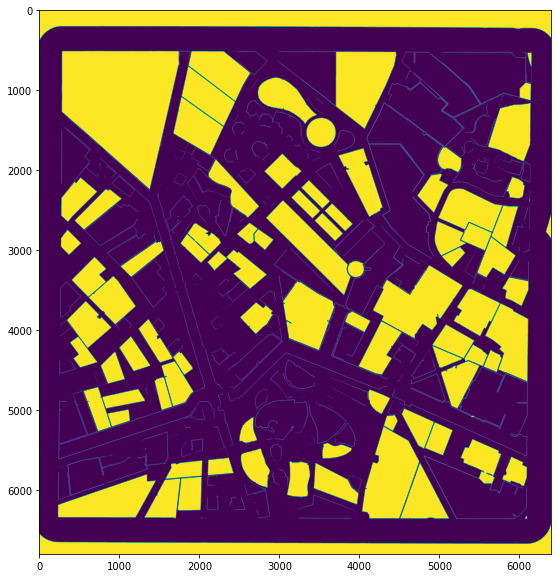

In [93]:
show_image(edges_filtered)

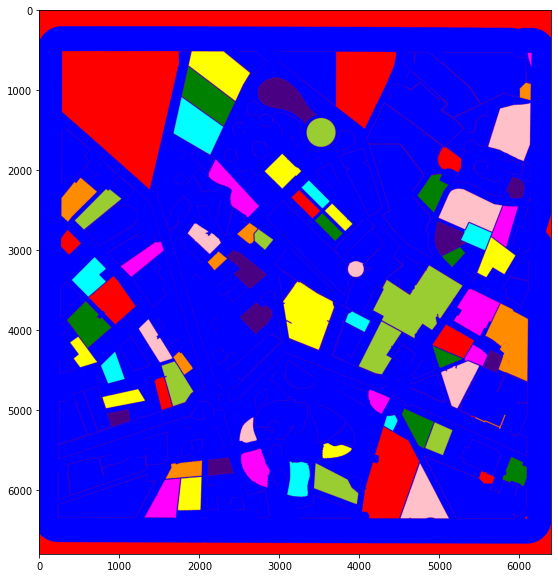

In [87]:
show_image(color.label2rgb(label(1 - edges, connectivity=1)))